# 1 задача

In [29]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Модель без SGD

In [30]:
def model(features, labels, initial_weights, initial_bias, learning_rate, epochs):
  if not isinstance(features, torch.Tensor):
    features = torch.tensor(features, dtype=torch.float32)
  if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels, dtype=torch.float32)
  if not isinstance(initial_weights, torch.Tensor):
    updated_weights = torch.tensor(initial_weights, dtype=torch.float32)
  else:
    updated_weights = initial_weights.clone().detach()

  updated_bias = float(initial_bias)
  nll_values = []
  eps = 1e-8
  N = len(features)

  for epoch in range(epochs):
    y_pred = torch.sigmoid(updated_weights @ features.T + updated_bias)

    loss = -torch.sum(labels * torch.log(y_pred + eps) + (1 - labels) * torch.log(1 - y_pred + eps)) / N
    nll_values.append(round(loss.item(), 4))

    diff = y_pred - labels
    grad_b = torch.sum(diff) / N
    grad_w =  ((diff) @ features) / N

    updated_weights -= learning_rate * grad_w
    updated_bias -= learning_rate * grad_b


  return updated_weights, updated_bias, nll_values

In [31]:
features = torch.tensor([[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]])
labels = torch.tensor([1, 0, 0])
initial_weights = torch.tensor([0.1, -0.2])
initial_bias = 0.0
learning_rate = 0.1
epochs = 2

In [32]:
model(features, labels, initial_weights, initial_bias, learning_rate, epochs)

(tensor([ 0.1070, -0.0847]), tensor(-0.0335), [0.8006, 0.7631])

## Тренировка на данных

In [36]:
data_x = pd.read_csv('/content/train_x.csv')
data_y = pd.read_csv('/content/train_y.csv')

In [37]:
data_x.rename(columns={'Unnamed: 0': 'key'}, inplace=True)
data_y.rename(columns={'Unnamed: 0': 'key'}, inplace=True)

In [38]:
train_data = pd.merge(data_x, data_y, how='left', on=['key'])
train_data.head()

,key,0,1,2,3,4,5,6,7,8,...,81,82,83,84,85,86,87,88,89,year
0,133081,37.47518,-14.34414,40.54872,-9.10171,16.77175,-17.77113,-16.50156,-4.09543,2.49723,...,-115.62803,-13.79660,31.60436,28.95927,-25.93164,67.64670,-25.76691,-81.90373,-61.48682,2001
1,111484,48.17393,-7.02208,-30.36086,-2.41924,2.15406,-8.44502,-1.68191,-8.71434,-7.83802,...,24.58950,-36.95682,0.73922,-0.06330,53.75838,-81.05330,8.42811,12.08694,-1.91676,2006
2,448402,36.58141,26.03203,-4.92774,35.71620,8.53080,3.73167,-7.98443,-7.43976,-1.69797,...,-366.07968,-62.38201,113.48188,4.72741,181.64459,-134.46216,8.50795,94.15573,-8.47276,1989
3,254414,41.15615,-17.77029,-32.30961,-21.03778,12.80330,-13.48031,-3.14951,-7.62647,-4.48901,...,-79.64532,-77.08169,38.88094,28.52025,24.17783,-86.62542,-1.19418,-74.73449,-17.28130,1997
4,272580,40.54855,78.77563,-23.29877,98.60192,-30.11496,26.94220,-8.87771,-3.23280,-1.04841,...,-252.61021,118.93768,-155.87390,51.85666,-365.15815,59.34936,52.47311,99.00695,-10.18840,2001


In [39]:
train_data['year'].value_counts()

,count
year,
2007,1062
2006,976
2005,949
2008,901
2009,793
...,...
1941,1
1925,1
1931,1


In [40]:
train_data_short = train_data[(train_data['year'] == 2006) | (train_data['year'] == 2007)]

In [41]:
X = train_data_short.drop(columns=['key', 'year'])
y = train_data_short['year'] - 2006

In [42]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_scaled, y, test_size=0.3, random_state=42)

In [44]:
features = X_train
labels = y_train.values
initial_weights = torch.rand(X_train.shape[1])
initial_bias = 0.0
learning_rate = 0.1
epochs = 100

weights, bias, losses = model(features, labels, initial_weights, initial_bias, learning_rate, epochs)

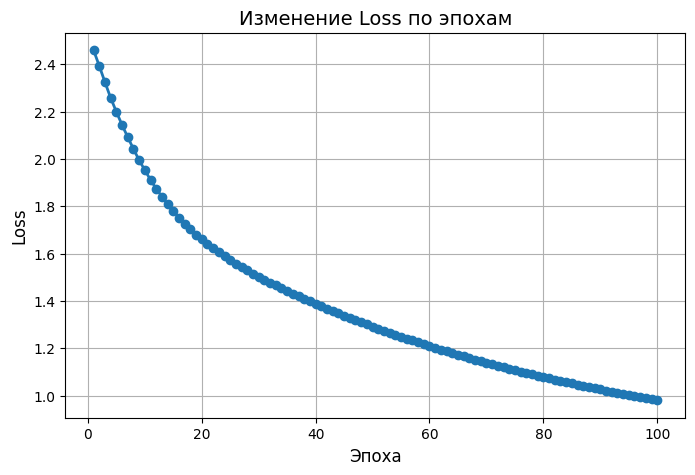

In [45]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses) + 1), losses, marker='o', linestyle='-', linewidth=2)
plt.title('Изменение Loss по эпохам', fontsize=14)
plt.xlabel('Эпоха', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.show()


In [46]:
def get_loss(X, y, weights, bias):
  if not isinstance(X, torch.Tensor):
    X = torch.tensor(X, dtype=torch.float32)
  if not isinstance(y, torch.Tensor):
    y = torch.tensor(y, dtype=torch.float32)
  if not isinstance(weights, torch.Tensor):
    weights = torch.tensor(weights, dtype=torch.float32)

  N = len(X)
  eps = 1e-8
  y_pred = torch.sigmoid(weights @ X.T + bias)
  loss = -torch.sum(y * torch.log(y_pred + eps) + (1 - y) * torch.log(1 - y_pred + eps)) / N
  return round(loss.item(), 4)

In [47]:
test_loss = get_loss(weights, bias, X_test, y_test.values)
print(f"TEST LOSS: {test_loss}")

TEST LOSS: 8.7516


/tmp/ipython-input-562763470.py:11: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4421.)
  y_pred = torch.sigmoid(weights @ X.T + bias)
/tmp/ipython-input-562763470.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y_pred = torch.sigmoid(weights @ X.T + bias)


## Модель с SGD

In [48]:
def model_sgd(features, labels, initial_weights, initial_bias, learning_rate, epochs):
  if not isinstance(features, torch.Tensor):
    features = torch.tensor(features, dtype=torch.float32)
  if not isinstance(labels, torch.Tensor):
    labels = torch.tensor(labels, dtype=torch.float32)
  if not isinstance(initial_weights, torch.Tensor):
    updated_weights = torch.tensor(initial_weights, dtype=torch.float32)
  else:
    updated_weights = initial_weights.clone().detach()

  updated_bias = float(initial_bias)
  nll_values = []
  eps = 1e-8
  N = len(features)

  for epoch in range(epochs):
    indexes = torch.randperm(N)
    mean_loss = 0
    for ind in indexes:
      curr_X = features[ind].unsqueeze(0)
      curr_y = labels[ind]

      y_pred = torch.sigmoid(updated_weights @ curr_X.T + updated_bias)

      loss = -(curr_y * torch.log(y_pred + eps) + (1 - curr_y) * torch.log(1 - y_pred + eps))

      diff = torch.tensor([[y_pred - curr_y]], dtype=torch.float32)
      grad_b = diff.item()
      grad_w =  ((diff) @ curr_X).squeeze(0)

      updated_weights -= learning_rate * grad_w
      updated_bias -= learning_rate * grad_b
      mean_loss += loss.item()

    mean_loss /= N
    nll_values.append(round(mean_loss, 4))

  return updated_weights, updated_bias, nll_values

In [49]:
features = torch.tensor([[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]])
labels = torch.tensor([1, 0, 0])
initial_weights = torch.tensor([0.1, -0.2])
initial_bias = 0.0
learning_rate = 0.1
epochs = 3

model_sgd(features, labels, initial_weights, initial_bias, learning_rate, epochs)

(tensor([0.0492, 0.2213]), -0.15692155659198762, [0.8406, 0.7454, 0.6722])

## Сравнение моделей

In [112]:
def train_model(features, labels, initial_weights, initial_bias, lr, epochs, stochastic=False):
    if not isinstance(features, torch.Tensor):
      features = torch.tensor(features, dtype=torch.float32)
    if not isinstance(labels, torch.Tensor):
      labels = torch.tensor(labels, dtype=torch.float32)
    if not isinstance(initial_weights, torch.Tensor):
      updated_weights = torch.tensor(initial_weights, dtype=torch.float32)
    else:
      updated_weights = initial_weights.clone().detach()

    updated_bias = float(initial_bias)
    losses = []
    path = []
    eps = 1e-8
    N = len(features)

    for epoch in range(epochs):
        if stochastic:
            indexes = torch.randperm(N)
            mean_loss = 0
            for ind in indexes:
              curr_X = features[ind].unsqueeze(0)
              curr_y = labels[ind]

              y_pred = torch.sigmoid(updated_weights @ curr_X.T + updated_bias)

              loss = -(curr_y * torch.log(y_pred + eps) + (1 - curr_y) * torch.log(1 - y_pred + eps))

              diff = torch.tensor([[y_pred - curr_y]], dtype=torch.float32)
              grad_b = diff.item()
              grad_w =  ((diff) @ curr_X).squeeze(0)

              updated_weights -= learning_rate * grad_w
              updated_bias -= learning_rate * grad_b
              mean_loss += loss.item()

            mean_loss /= N
            losses.append(round(mean_loss, 4))
        else:
            y_pred = torch.sigmoid(updated_weights @ features.T + updated_bias)

            loss = -torch.sum(labels * torch.log(y_pred + eps) + (1 - labels) * torch.log(1 - y_pred + eps)) / N
            losses.append(round(loss.item(), 4))

            diff = y_pred - labels
            grad_b = torch.sum(diff) / N
            grad_w =  ((diff) @ features) / N

            updated_weights -= learning_rate * grad_w
            updated_bias -= learning_rate * grad_b

        path.append(updated_weights.clone().detach().numpy())

    return np.array(path), losses

### XOR датасет

In [113]:
rng = np.random.RandomState(0)
N_x = 200
X = np.vstack([
    rng.normal(loc=[-1, -1], scale=0.5, size=(N_x//4, 2)),
    rng.normal(loc=[1, 1], scale=0.5, size=(N_x//4, 2)),
    rng.normal(loc=[-1, 1], scale=0.5, size=(N_x//4, 2)),
    rng.normal(loc=[1, -1], scale=0.5, size=(N_x//4, 2))
])
y = np.hstack([
    np.zeros(N_x//4),
    np.zeros(N_x//4),
    np.ones(N_x//4),
    np.ones(N_x//4)
])

features = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(y, dtype=torch.float32)

In [114]:
features.shape

torch.Size([200, 2])

In [115]:
labels.shape

torch.Size([200])

In [116]:
initial_weights = torch.rand(2)
initial_bias = 0.0
epochs = 40
lr = 0.1
path_gd, loss_gd = train_model(features, labels, initial_weights, initial_bias, lr, epochs, stochastic=False)
path_sgd, loss_sgd = train_model(features, labels, initial_weights, initial_bias, lr, epochs, stochastic=True)

In [117]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    """Сигмоидная функция активации."""
    return 1 / (1 + torch.exp(-x))


def nll_loss(y_true: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    """
    Negative Log-Likelihood Loss (бинарный случай).

    y_true — тензор с метками (0 или 1)
    y_pred — тензор с предсказанными вероятностями (между 0 и 1)
    """
    # Добавляем небольшое число, чтобы избежать log(0)
    eps = 1e-8
    loss = - (y_true * torch.log(y_pred + eps) + (1 - y_true) * torch.log(1 - y_pred + eps))
    return loss.mean()

def compute_surface(X, y, xlim, ylim, res=200):
    W0 = np.linspace(xlim[0], xlim[1], res)
    W1 = np.linspace(ylim[0], ylim[1], res)
    W0g, W1g = np.meshgrid(W0, W1)
    Z = np.zeros_like(W0g)
    for i in range(W0g.shape[0]):
        for j in range(W0g.shape[1]):
            w = torch.tensor([W0g[i, j], W1g[i, j]], dtype=torch.float32)
            y_pred = sigmoid(features @ w)
            Z[i, j] = nll_loss(labels, y_pred).item()
    return W0g, W1g, Z

def get_bounds(path1, path2, margin=0.5):
    all_w = np.vstack([path1, path2])
    w0_min, w0_max = all_w[:,0].min() - margin, all_w[:,0].max() + margin
    w1_min, w1_max = all_w[:,1].min() - margin, all_w[:,1].max() + margin
    return (w0_min, w0_max), (w1_min, w1_max)

xlim, ylim = get_bounds(path_gd, path_sgd)
W0g, W1g, Z = compute_surface(features, labels, xlim, ylim)

/tmp/ipython-input-428908291.py:8: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[0].scatter(path_gd[-1,0], path_gd[-1,1], color='red', s=100, edgecolors='black', marker='x', label='End')
/tmp/ipython-input-428908291.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[1].scatter(path_sgd[-1,0], path_sgd[-1,1], color='white', s=100, edgecolors='black', marker='x', label='End')


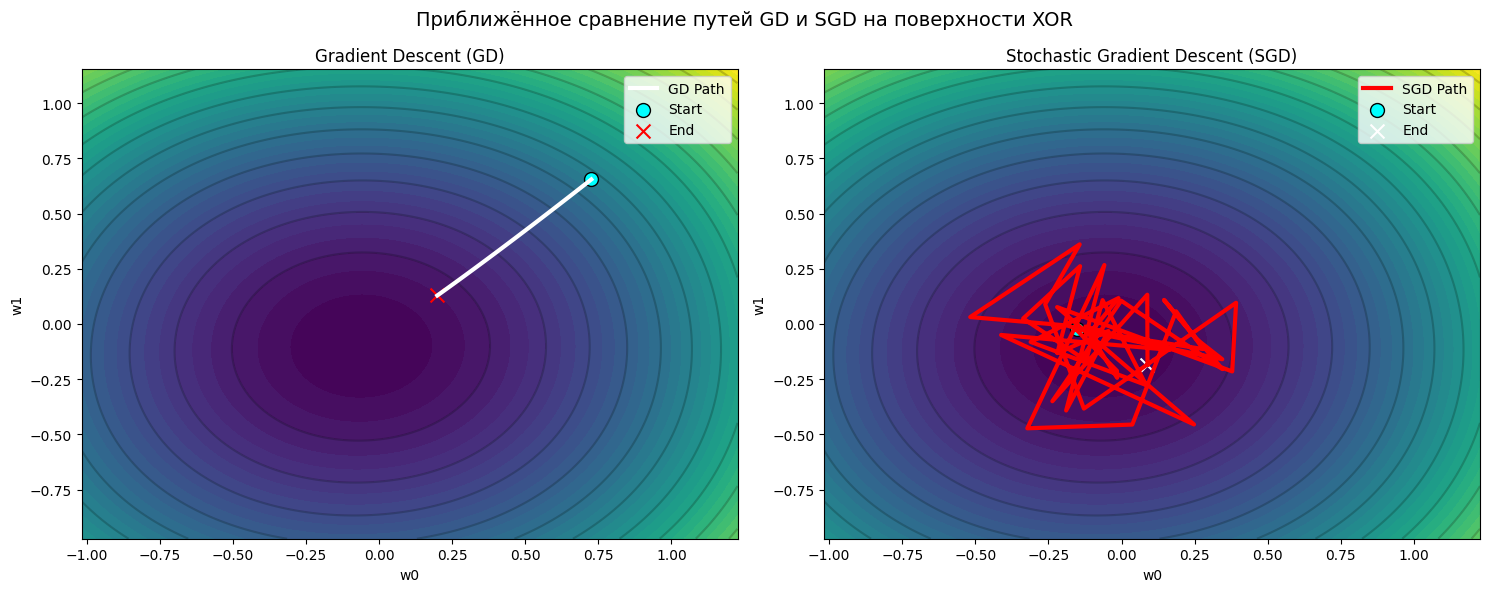

In [118]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- GD ---
axes[0].contourf(W0g, W1g, Z, levels=40, cmap='viridis')
axes[0].contour(W0g, W1g, Z, levels=15, colors='black', alpha=0.2)
axes[0].plot(path_gd[:,0], path_gd[:,1], color='white', linewidth=3, label='GD Path')
axes[0].scatter(path_gd[0,0], path_gd[0,1], color='cyan', s=100, edgecolors='black', label='Start')
axes[0].scatter(path_gd[-1,0], path_gd[-1,1], color='red', s=100, edgecolors='black', marker='x', label='End')
axes[0].set_title("Gradient Descent (GD)")
axes[0].set_xlabel("w0")
axes[0].set_ylabel("w1")
axes[0].legend()
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# --- SGD ---
axes[1].contourf(W0g, W1g, Z, levels=40, cmap='viridis')
axes[1].contour(W0g, W1g, Z, levels=15, colors='black', alpha=0.2)
axes[1].plot(path_sgd[:,0], path_sgd[:,1], color='red', linewidth=3, label='SGD Path')
axes[1].scatter(path_sgd[0,0], path_sgd[0,1], color='cyan', s=100, edgecolors='black', label='Start')
axes[1].scatter(path_sgd[-1,0], path_sgd[-1,1], color='white', s=100, edgecolors='black', marker='x', label='End')
axes[1].set_title("Stochastic Gradient Descent (SGD)")
axes[1].set_xlabel("w0")
axes[1].set_ylabel("w1")
axes[1].legend()
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)

plt.suptitle("Приближённое сравнение путей GD и SGD на поверхности XOR", fontsize=14)
plt.tight_layout()
plt.show()

### Линейно разделимые данные

In [119]:
rng = np.random.RandomState(1)
N_x = 200
X_pos = rng.normal(loc=[2, 2], scale=0.6, size=(N_x//2, 2))
X_neg = rng.normal(loc=[-2, -2], scale=0.6, size=(N_x//2, 2))
X = np.vstack([X_pos, X_neg])
y = np.hstack([np.ones(N_x//2), np.zeros(N_x//2)])

features = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(y, dtype=torch.float32)

In [120]:
initial_weights = torch.rand(2)
initial_bias = 0.0
epochs = 40
lr = 0.1
path_gd, loss_gd = train_model(features, labels, initial_weights, initial_bias, lr, epochs, stochastic=False)
path_sgd, loss_sgd = train_model(features, labels, initial_weights, initial_bias, lr, epochs, stochastic=True)

In [121]:
xlim, ylim = get_bounds(path_gd, path_sgd)
W0g, W1g, Z = compute_surface(features, labels, xlim, ylim)

/tmp/ipython-input-1556109500.py:8: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[0].scatter(path_gd[-1,0], path_gd[-1,1], color='red', s=100, edgecolors='black', marker='x', label='End')
/tmp/ipython-input-1556109500.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[1].scatter(path_sgd[-1,0], path_sgd[-1,1], color='white', s=100, edgecolors='black', marker='x', label='End')


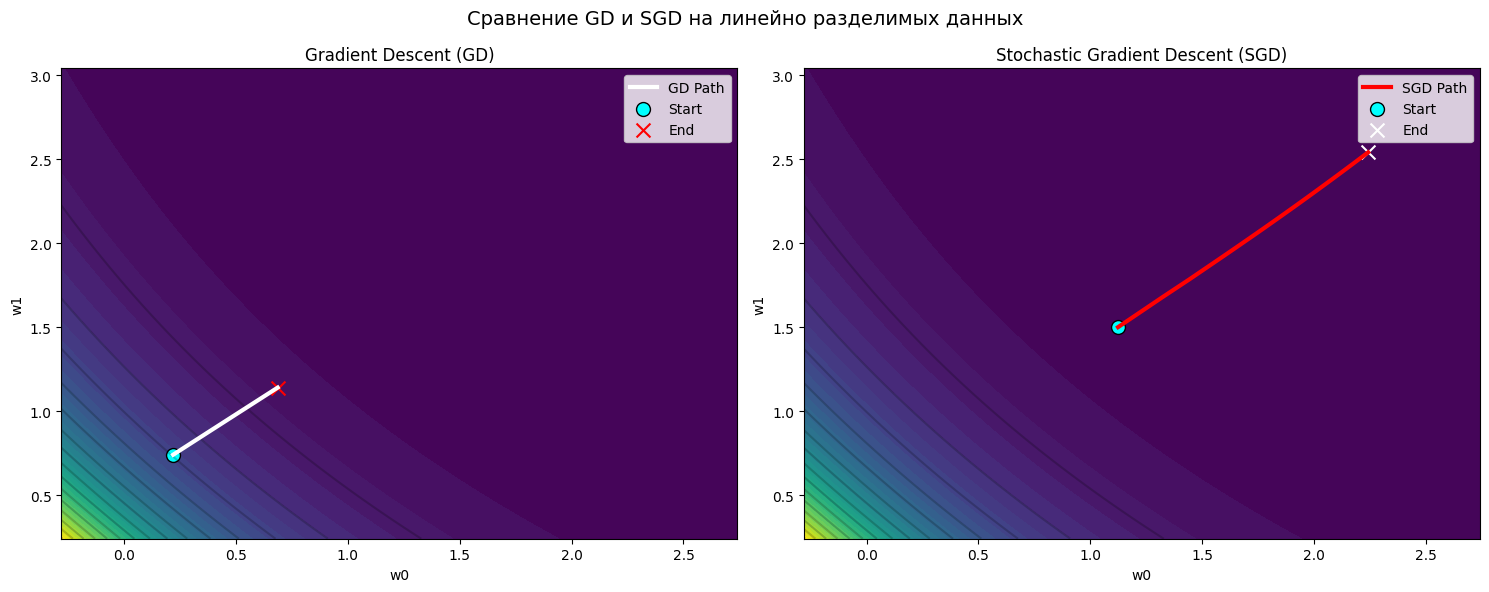

In [122]:
ig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- GD ---
axes[0].contourf(W0g, W1g, Z, levels=40, cmap='viridis')
axes[0].contour(W0g, W1g, Z, levels=15, colors='black', alpha=0.2)
axes[0].plot(path_gd[:,0], path_gd[:,1], color='white', linewidth=3, label='GD Path')
axes[0].scatter(path_gd[0,0], path_gd[0,1], color='cyan', s=100, edgecolors='black', label='Start')
axes[0].scatter(path_gd[-1,0], path_gd[-1,1], color='red', s=100, edgecolors='black', marker='x', label='End')
axes[0].set_title("Gradient Descent (GD)")
axes[0].set_xlabel("w0")
axes[0].set_ylabel("w1")
axes[0].legend()
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# --- SGD ---
axes[1].contourf(W0g, W1g, Z, levels=40, cmap='viridis')
axes[1].contour(W0g, W1g, Z, levels=15, colors='black', alpha=0.2)
axes[1].plot(path_sgd[:,0], path_sgd[:,1], color='red', linewidth=3, label='SGD Path')
axes[1].scatter(path_sgd[0,0], path_sgd[0,1], color='cyan', s=100, edgecolors='black', label='Start')
axes[1].scatter(path_sgd[-1,0], path_sgd[-1,1], color='white', s=100, edgecolors='black', marker='x', label='End')
axes[1].set_title("Stochastic Gradient Descent (SGD)")
axes[1].set_xlabel("w0")
axes[1].set_ylabel("w1")
axes[1].legend()
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)

plt.suptitle("Сравнение GD и SGD на линейно разделимых данных", fontsize=14)
plt.tight_layout()
plt.show()

### Две вытянутые кучи

In [123]:
rng = np.random.RandomState(2)
N = 200


X_pos = rng.normal(loc=[0, 3], scale=[0.2, 1.5], size=(N//2, 2))
X_neg = rng.normal(loc=[0, -3], scale=[0.2, 1.5], size=(N//2, 2))
X = np.vstack([X_pos, X_neg])
y = np.hstack([np.ones(N//2), np.zeros(N//2)])

features = torch.tensor(X, dtype=torch.float32)
labels = torch.tensor(y, dtype=torch.float32)

In [124]:
features.shape

torch.Size([200, 2])

In [125]:
labels.shape

torch.Size([200])

In [126]:
initial_weights = torch.rand(2)
initial_bias = 0.0
epochs = 40
lr = 0.1
path_gd, loss_gd = train_model(features, labels, initial_weights, initial_bias, lr, epochs, stochastic=False)
path_sgd, loss_sgd = train_model(features, labels, initial_weights, initial_bias, lr, epochs, stochastic=True)

In [127]:
xlim, ylim = get_bounds(path_gd, path_sgd)
W0g, W1g, Z = compute_surface(features, labels, xlim, ylim)

/tmp/ipython-input-761624555.py:8: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[0].scatter(path_gd[-1,0], path_gd[-1,1], color='red', s=100, edgecolors='black', marker='x', label='End')
/tmp/ipython-input-761624555.py:21: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  axes[1].scatter(path_sgd[-1,0], path_sgd[-1,1], color='white', s=100, edgecolors='black', marker='x', label='End')


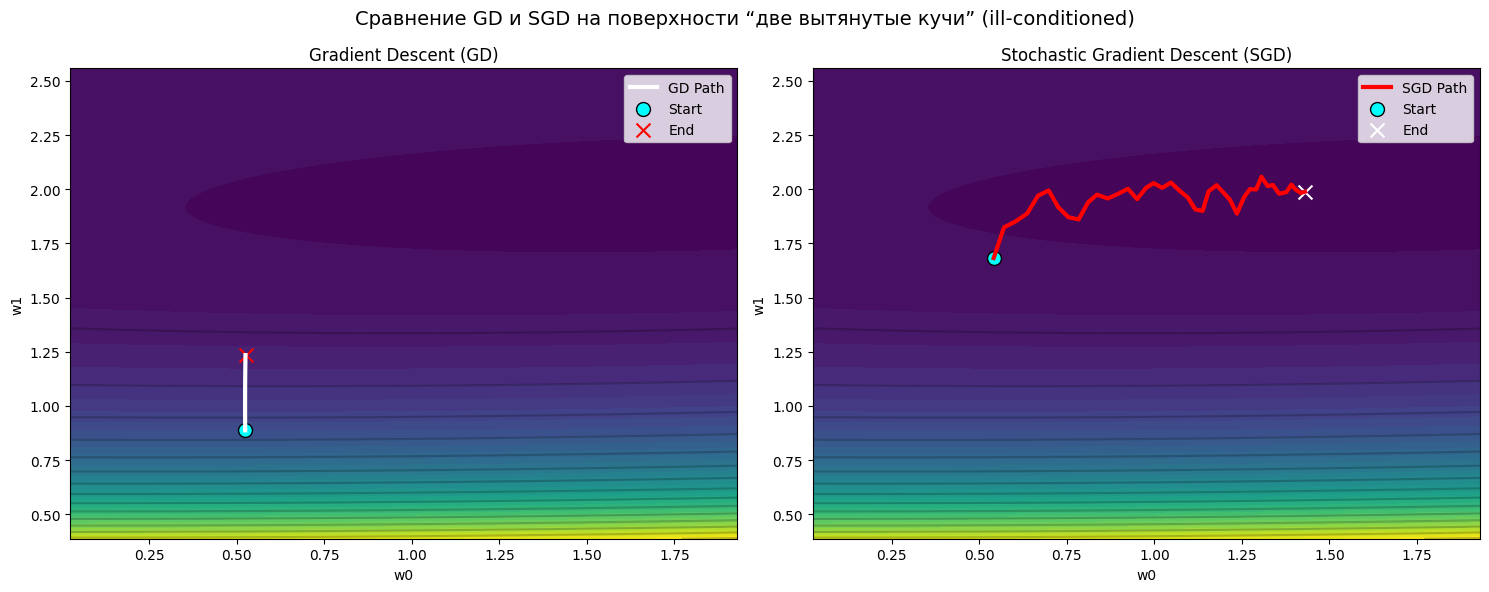

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# --- GD ---
axes[0].contourf(W0g, W1g, Z, levels=40, cmap='viridis')
axes[0].contour(W0g, W1g, Z, levels=15, colors='black', alpha=0.2)
axes[0].plot(path_gd[:,0], path_gd[:,1], color='white', linewidth=3, label='GD Path')
axes[0].scatter(path_gd[0,0], path_gd[0,1], color='cyan', s=100, edgecolors='black', label='Start')
axes[0].scatter(path_gd[-1,0], path_gd[-1,1], color='red', s=100, edgecolors='black', marker='x', label='End')
axes[0].set_title("Gradient Descent (GD)")
axes[0].set_xlabel("w0")
axes[0].set_ylabel("w1")
axes[0].legend()
axes[0].set_xlim(xlim)
axes[0].set_ylim(ylim)

# --- SGD ---
axes[1].contourf(W0g, W1g, Z, levels=40, cmap='viridis')
axes[1].contour(W0g, W1g, Z, levels=15, colors='black', alpha=0.2)
axes[1].plot(path_sgd[:,0], path_sgd[:,1], color='red', linewidth=3, label='SGD Path')
axes[1].scatter(path_sgd[0,0], path_sgd[0,1], color='cyan', s=100, edgecolors='black', label='Start')
axes[1].scatter(path_sgd[-1,0], path_sgd[-1,1], color='white', s=100, edgecolors='black', marker='x', label='End')
axes[1].set_title("Stochastic Gradient Descent (SGD)")
axes[1].set_xlabel("w0")
axes[1].set_ylabel("w1")
axes[1].legend()
axes[1].set_xlim(xlim)
axes[1].set_ylim(ylim)

plt.suptitle("Сравнение GD и SGD на поверхности “две вытянутые кучи” (ill-conditioned)", fontsize=14)
plt.tight_layout()
plt.show()

# 2 задача

In [129]:
class Node:
  def __init__(self, data, _children=(), _op=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op

  def __repr__(self):
    return f" Node(data={self.data}, grad={self.grad})"

  def __add__(self, other):
    out = Node(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    out._backward = _backward
    return out

  def __mul__(self, other):
    out = Node(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def relu(self):
    out = Node(max(0, self.data), (self, ), "relu")

    def _backward():
      self.grad += (out.data > 0) * out.grad

    out._backward = _backward
    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)

    self.grad = 1
    for v in reversed(topo):
        v._backward()


In [130]:
a = Node(2)
b = Node(-3)
c = Node(10)
d = a + b * c
e = d.relu()
e.backward()
print(a, b, c, d, e)

 Node(data=2, grad=0.0)  Node(data=-3, grad=0.0)  Node(data=10, grad=0.0)  Node(data=-28, grad=0)  Node(data=0, grad=1)


# 3 задача

In [131]:
class NLL:
  def __init__(self, in_features):
    self.W = torch.rand(in_features + 1)

  @staticmethod
  def get_loss(y, y_pred):
    eps = 1e-8
    N = len(y)
    loss = -torch.sum(y * torch.log(y_pred + eps) + (1 - y) * torch.log(1 - y_pred + eps)) / N
    return loss.item()

  @staticmethod
  def get_grad(X, y, y_pred):
    X = torch.concatenate((X, torch.ones((X.shape[0], 1))), dim=1)
    N = X.shape[0]
    diff = y_pred - y
    grad_w =  ((diff) @ X) / N
    return grad_w

  def forward(self, X):
    X = torch.concatenate((X, torch.ones((X.shape[0], 1))), dim=1)
    return torch.sigmoid(self.W @ X.T)

  def add_weight(self, delta):
    self.W += delta

  def get_weight(self):
    return self.W

In [132]:
class AdamW:
  def __init__(self, model, lr=0.1, weight_decay=0.1, mu_g = 0.7, mu_v=0.7):
    self.W = None
    self.g = None
    self.v = None
    self.model = model
    self.lr = lr
    self.weight_decay = weight_decay
    self.eps = 1e-8
    self.mu_g = mu_g
    self.mu_v = mu_v

  def step(self, X, y, y_pred, n_step):
    loss = self.model.get_loss(y, y_pred)
    grad = self.model.get_grad(X, y, y_pred)

    self.g = self.mu_g*self.g + (1 - self.mu_g)*grad
    self.v = self.mu_v*self.v + (1 - self.mu_v)*(grad * grad)
    g_hat = self.g / (1 - self.mu_g**n_step)
    v_hat = self.v / (1 - self.mu_v**n_step)
    delta = -self.lr * (self.weight_decay * self.model.get_weight() + g_hat / (torch.sqrt(v_hat) + self.eps))
    model.add_weight(delta)
    return loss


  def _pred(self, X):
    return torch.sigmoid(self.W @ X.T)

  def optim(self, X, y, epochs):
    self.g = torch.zeros_like(self.model.get_weight())
    self.v = torch.zeros_like(self.model.get_weight())
    for epoch in range(1, epochs):
      y_pred = self.model.forward(X)
      loss = self.step(X, y, y_pred, n_step=epoch)
      print(loss)

    return self.model.get_weight()


In [133]:
X = torch.tensor([[1.0, 2.0], [2.0, 1.0], [-1.0, -2.0]])
y = torch.tensor([1, 0, 0])

In [134]:
X.shape[1]

2

In [135]:
model = NLL(X.shape[1])
optimizer = AdamW(model)
optimizer.optim(X, y, 10)

0.9425955414772034
0.8356173038482666
0.742913544178009
0.6679399609565735
0.6105064749717712
0.5611398816108704
0.5142413973808289
0.47025254368782043
0.4299333095550537


tensor([-0.2323,  0.6718, -0.4693])

## Тесты

### На уменьшение градиента

In [136]:
class DummyModel:
    def __init__(self):
        self.W = torch.zeros(3)

    def forward(self, X):
        return X @ self.W

    def get_loss(self, y, y_pred):
        return torch.mean((y - y_pred) ** 2)

    def get_grad(self, X, y, y_pred):
        return -2 * X.T @ (y - y_pred) / len(y)

    def get_weight(self):
        return self.W

    def add_weight(self, delta):
        self.W += delta

X = torch.randn(10, 3)
y = torch.randn(10)

model = DummyModel()
opt = AdamW(model, lr=0.1)

opt.optim(X, y, epochs=5)


tensor(0.3123)
tensor(0.2523)
tensor(0.1914)
tensor(0.1572)


tensor([-0.3330, -0.1444,  0.3463])

### На сходимость к минимуму квадратичной функции

In [137]:
# Модель: f(w) = (w - 3)^2
class QuadraticModel:
    def __init__(self):
        self.W = torch.tensor([5.0])  # старт не в минимуме

    def forward(self, X):
        return self.W * X  # фиктивный forward

    def get_loss(self, y, y_pred):
        return (self.W - 3).pow(2)

    def get_grad(self, X, y, y_pred):
        return 2 * (self.W - 3)

    def get_weight(self):
        return self.W

    def add_weight(self, delta):
        self.W += delta

# Запуск
model = QuadraticModel()
opt = AdamW(model, lr=0.1)
opt.g = torch.zeros(1)
opt.v = torch.zeros(1)

for step in range(1, 101):
    y_pred = model.forward(torch.tensor([1.0]))
    loss = opt.step(torch.tensor([1.0]), torch.tensor([1.0]), y_pred, step)

print(f"Final W: {model.W.item()}, loss: {loss.item()}")


Final W: 2.99607515335083, loss: 0.00042165652848780155


### На Weight Decay

In [138]:
class NoGradModel:
    def __init__(self):
        self.W = torch.tensor([10.0])

    def forward(self, X):
      return X
    def get_loss(self, y, y_pred):
      return torch.tensor(0.0)
    def get_grad(self, X, y, y_pred):
      return torch.tensor(0.0)
    def get_weight(self):
      return self.W
    def add_weight(self, delta):
      self.W += delta

model = NoGradModel()
opt = AdamW(model, lr=0.1, weight_decay=0.8)
opt.g = torch.zeros(1)
opt.v = torch.zeros(1)

for step in range(1, 20):
    opt.step(None, None, None, step)
    print(model.W)



tensor([9.2000])
tensor([8.4640])
tensor([7.7869])
tensor([7.1639])
tensor([6.5908])
tensor([6.0635])
tensor([5.5785])
tensor([5.1322])
tensor([4.7216])
tensor([4.3439])
tensor([3.9964])
tensor([3.6767])
tensor([3.3825])
tensor([3.1119])
tensor([2.8630])
tensor([2.6339])
tensor([2.4232])
tensor([2.2294])
tensor([2.0510])
